# Passive Learning
- manual

Birth-Death Record Linkage System
Loading datasets...
Birth records: 2508 rows, 35 columns
Death records: 1832 rows, 37 columns

Birth Records Columns:
['ID', 'family', 'marriage', "child's forname(s)", "child's surname", 'birth day', 'birth month', 'birth year', 'address', 'sex', "father's forename", "father's surname", "father's occupation", "mother's forename", "mother's maiden surname", "mother's occupation", "day of parents' marriage", "month of parents' marriage", "year of parents' marriage", "place of parent's marriage", 'illegit', 'notes', 'Death', 'CHILD_IDENTITY', 'MOTHER_IDENTITY', 'FATHER_IDENTITY', 'DEATH_RECORD_IDENTITY', 'PARENT_MARRIAGE_RECORD_IDENTITY', 'FATHER_BIRTH_RECORD_IDENTITY', 'MOTHER_BIRTH_RECORD_IDENTITY', 'MARRIAGE_RECORD_IDENTITY1', 'MARRIAGE_RECORD_IDENTITY2', 'MARRIAGE_RECORD_IDENTITY3', 'MARRIAGE_RECORD_IDENTITY4', 'MARRIAGE_RECORD_IDENTITY5']

Death Records Columns:
['ID', 'forename(s) of deceased', 'surname of deceased', 'occupation', 'marital status',

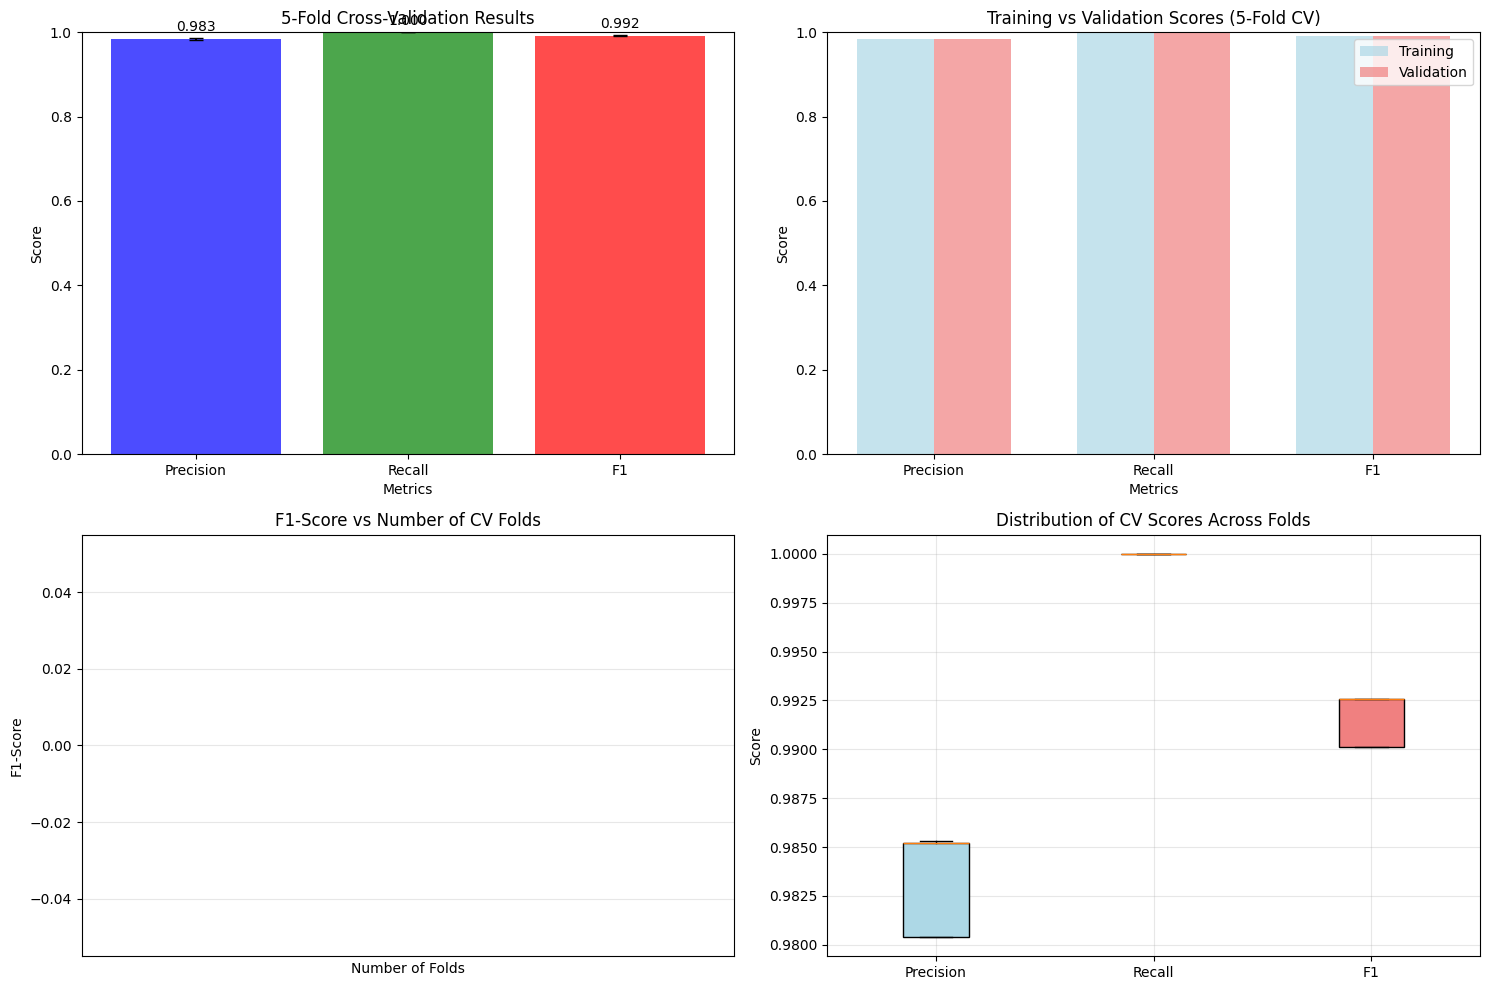



Learning Curve Analysis:
------------------------------


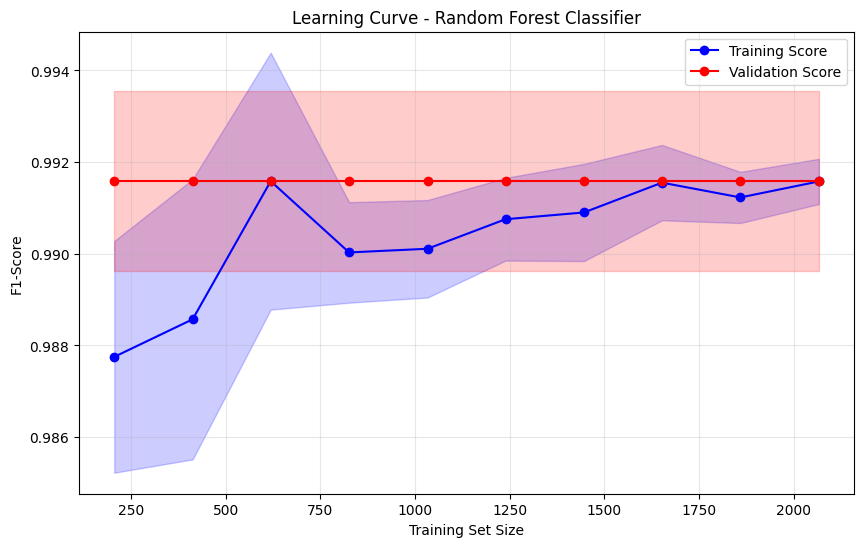

Learning curve shows performance with varying training set sizes.
Final validation F1-score: 0.9916 (+/- 0.0020)


Training Final Model on Training Set:
----------------------------------------
Classification completed!
Classification Results:
Precision: 0.9901
Recall: 1.0000
F1-Score: 0.9950

Confusion Matrix:
[[472   3]
 [  0 300]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       475
           1       0.99      1.00      1.00       300

    accuracy                           1.00       775
   macro avg       1.00      1.00      1.00       775
weighted avg       1.00      1.00      1.00       775



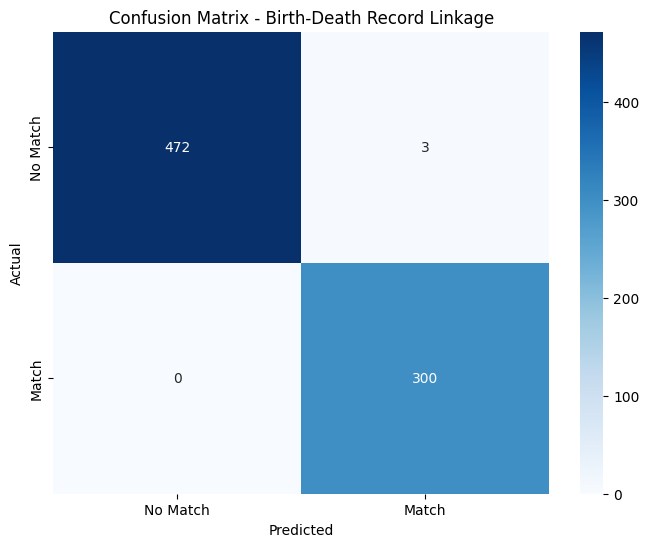


Top 10 Most Important Features:
                    feature  importance
24          age_consistency    0.390958
0               forename_jw    0.104513
2          forename_jaccard    0.100335
1               forename_dl    0.077777
10       father_forename_dl    0.066809
9        father_forename_jw    0.060631
16       mother_forename_dl    0.033537
11  father_forename_jaccard    0.032000
15       mother_forename_jw    0.024918
17  mother_forename_jaccard    0.022226


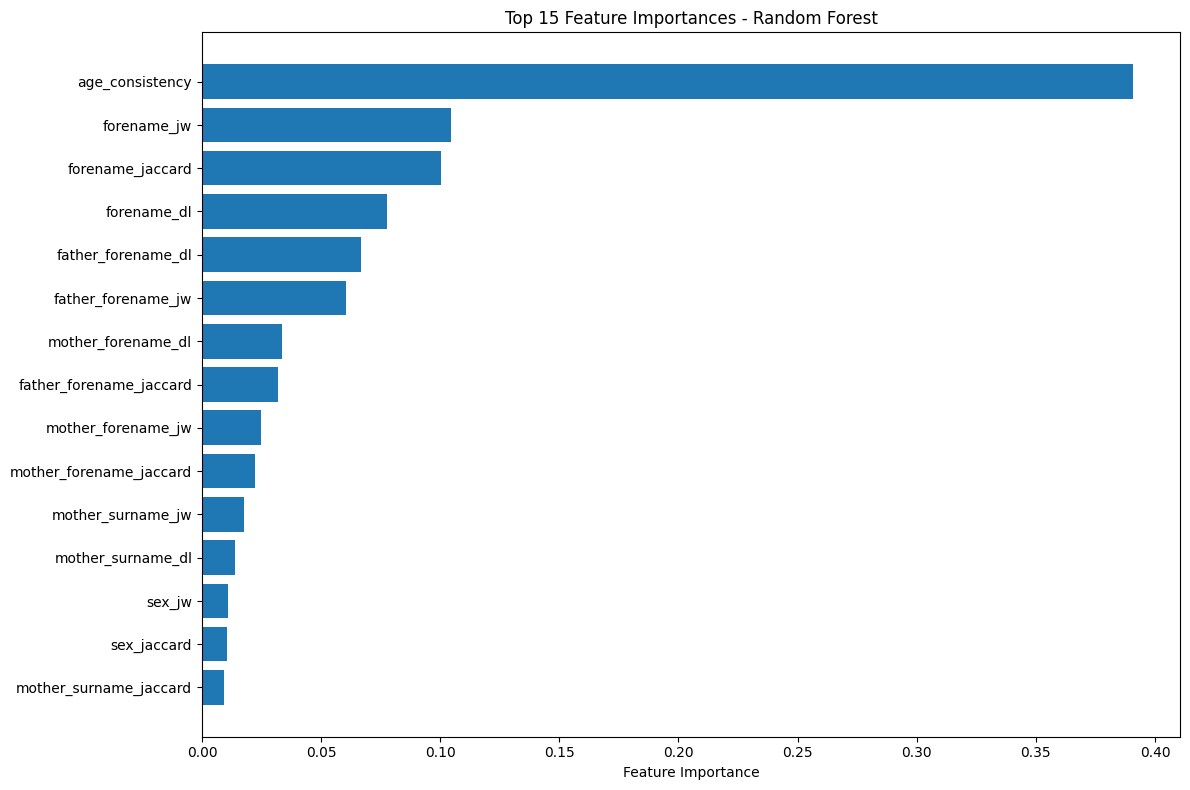

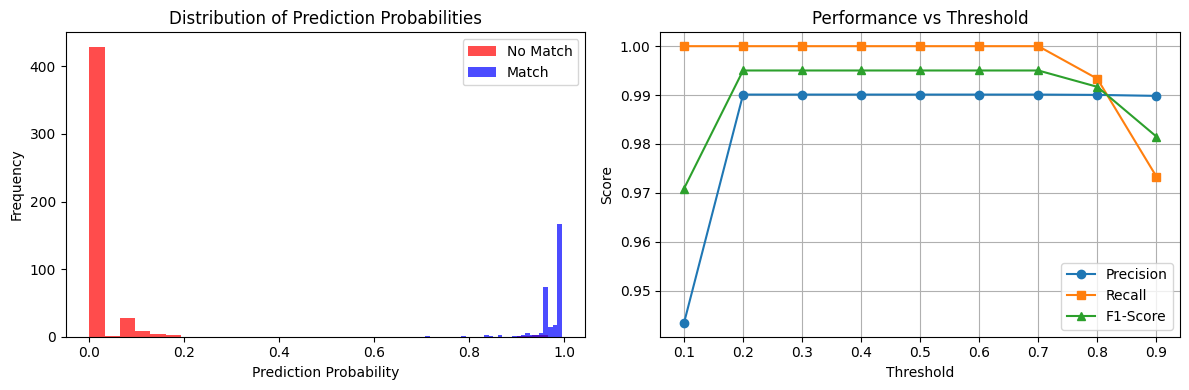


Cross-Validation Summary:
5-Fold Stratified Cross-Validation Results:
Precision: 0.9833 (+/- 0.0048)
Recall: 1.0000 (+/- 0.0000)
F1: 0.9916 (+/- 0.0024)

Final Model Performance on Test Set:
Total record pairs evaluated: 2583
Actual matches in test set: 300
Predicted matches in test set: 303
True positives: 300
False positives: 3
False negatives: 0
True negatives: 472

Test Set Performance:
Precision: 0.9901
Recall: 1.0000
F1-Score: 0.9950

Sample predictions:
   birth_id  death_id  actual_label  predicted_label  prediction_probability
0      4165      4165             0                0                0.000000
1      3555      3827             0                0                0.000000
2      5021      5169             0                0                0.000000
3      6905      3381             0                0                0.000000
4      3108      4190             0                0                0.000000
5      3873      3993             0                0                0.00

In [6]:
# Birth-Death Record Linkage Analysis
# A comprehensive record linkage system for linking birth and death records

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
# from jellyfish import jaro_winkler, damerau_levenshtein_distance
from jellyfish import jaro_similarity, jaro_winkler_similarity, levenshtein_distance, damerau_levenshtein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Birth-Death Record Linkage System")
print("=" * 50)

# %% [markdown]
# ## Step 1: Data Preprocessing


# %%
# Load the datasets
print("Loading datasets...")
birth_df = pd.read_csv('linkage data/_1/clean/birth_records.csv')
death_df = pd.read_csv('linkage data/_1/clean/death_records.csv')

print(f"Birth records: {birth_df.shape[0]} rows, {birth_df.shape[1]} columns")
print(f"Death records: {death_df.shape[0]} rows, {death_df.shape[1]} columns")

# %%
# Examine the structure of both datasets
print("\nBirth Records Columns:")
print(birth_df.columns.tolist())
print(f"\nDeath Records Columns:")
print(death_df.columns.tolist())

# %%
# Check for missing values
print("\nMissing values in Birth Records:")
print(birth_df.isnull().sum().head(10))
print(f"\nMissing values in Death Records:")
print(death_df.isnull().sum().head(10))

# %%
# Data preprocessing - select relevant columns for linkage
birth_columns = [
    'ID', 'child\'s forname(s)', 'child\'s surname', 'sex', 
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'birth year', 'address', 'Death'
]

death_columns = [
    'ID', 'forename(s) of deceased', 'surname of deceased', 'sex',
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'year', 'address', 'age at death'
]

# Create clean datasets
birth_clean = birth_df[birth_columns].copy()
death_clean = death_df[death_columns].copy()

# Rename columns for consistency
birth_clean.columns = ['birth_id', 'forename', 'surname', 'sex', 
                       'father_forename', 'father_surname', 'father_occupation',
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'birth_year', 'address', 'death_link']

death_clean.columns = ['death_id', 'forename', 'surname', 'sex',
                       'father_forename', 'father_surname', 'father_occupation', 
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'death_year', 'address', 'age_at_death']

# Fill missing values with empty strings for string columns
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'father_occupation', 'mother_forename', 'mother_surname', 
               'mother_occupation', 'address']

for col in string_cols:
    birth_clean[col] = birth_clean[col].fillna('').astype(str)
    death_clean[col] = death_clean[col].fillna('').astype(str)

print(f"\nCleaned Birth Records: {birth_clean.shape}")
print(f"Cleaned Death Records: {death_clean.shape}")

# %%
# Create ground truth labels using Death column from birth records and ID from death records
def create_ground_truth(birth_df, death_df):
    """Create ground truth labels for record pairs"""
    ground_truth = []
    
    # Create a mapping of death IDs for quick lookup
    death_ids = set(death_df['death_id'].values)
    
    for _, birth_row in birth_df.iterrows():
        birth_id = birth_row['birth_id']
        death_link = birth_row['death_link']
        
        for _, death_row in death_df.iterrows():
            death_id = death_row['death_id']
            
            # True match if death_link matches death_id
            if pd.notna(death_link) and int(death_link) == death_id:
                label = 1  # Match
            else:
                label = 0  # No match
                
            ground_truth.append({
                'birth_id': birth_id,
                'death_id': death_id,
                'label': label
            })
    
    return pd.DataFrame(ground_truth)

ground_truth_df = create_ground_truth(birth_clean, death_clean)
print(f"\nGround truth created: {len(ground_truth_df)} record pairs")
print(f"Positive matches: {ground_truth_df['label'].sum()}")
print(f"Negative matches: {len(ground_truth_df) - ground_truth_df['label'].sum()}")

# %% [markdown]
# ## Step 2: Indexing (Blocking)

# %%
def create_minhash_signature(record, columns):
    """Create MinHash signature for a record"""
    minhash = MinHash()
    for col in columns:
        data = str(record[col]).lower()
        for token in data.split():
            minhash.update(token.encode('utf8'))
    return minhash

def blocking_with_minhash(birth_df, death_df, threshold=0.7):
    """Create blocks using MinHash LSH"""
    print(f"Creating blocks with threshold: {threshold}")
    
    # Columns to use for blocking
    blocking_cols = ['forename', 'surname', 'father_surname', 'mother_surname']
    
    # Create MinHash signatures for all records
    birth_signatures = {}
    death_signatures = {}
    
    for idx, row in birth_df.iterrows():
        birth_signatures[f"birth_{row['birth_id']}"] = create_minhash_signature(row, blocking_cols)
    
    for idx, row in death_df.iterrows():
        death_signatures[f"death_{row['death_id']}"] = create_minhash_signature(row, blocking_cols)
    
    # Create LSH index
    lsh = MinHashLSH(threshold=threshold)
    
    # Insert all signatures
    for key, sig in birth_signatures.items():
        lsh.insert(key, sig)
    for key, sig in death_signatures.items():
        lsh.insert(key, sig)
    
    # Generate candidate pairs
    candidate_pairs = []
    
    for birth_key, birth_sig in birth_signatures.items():
        similar_records = lsh.query(birth_sig)
        birth_id = int(birth_key.split('_')[1])
        
        for similar_key in similar_records:
            if similar_key.startswith('death_'):
                death_id = int(similar_key.split('_')[1])
                candidate_pairs.append((birth_id, death_id))
    
    # Remove duplicates
    candidate_pairs = list(set(candidate_pairs))
    print(f"Generated {len(candidate_pairs)} candidate pairs")
    
    return candidate_pairs

# Generate candidate pairs through blocking
candidate_pairs = blocking_with_minhash(birth_clean, death_clean, threshold=0.6)

# %% [markdown]
# ## Step 3: Comparing (Feature Engineering)

# %%
def jaccard_similarity(str1, str2):
    """Calculate Jaccard similarity between two strings"""
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    if len(set1.union(set2)) == 0:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_features(birth_record, death_record):
    """Calculate similarity features between two records"""
    features = []
    
    # String comparison columns
    string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
                   'mother_forename', 'mother_surname', 'address']
    
    for col in string_cols:
        birth_val = str(birth_record[col]).lower()
        death_val = str(death_record[col]).lower()
        
        # Jaro-Winkler similarity
        jw_sim = jaro_winkler_similarity(birth_val, death_val)
        features.append(jw_sim)
        
        # Damerau-Levenshtein distance (normalized)
        dl_dist = damerau_levenshtein_distance(birth_val, death_val)
        max_len = max(len(birth_val), len(death_val))
        dl_sim = 1 - (dl_dist / max_len) if max_len > 0 else 1
        features.append(dl_sim)
        
        # Jaccard similarity
        jaccard_sim = jaccard_similarity(birth_val, death_val)
        features.append(jaccard_sim)
    
    # Age consistency (if available)
    if pd.notna(birth_record['birth_year']) and pd.notna(death_record['death_year']) and pd.notna(death_record['age_at_death']):
        expected_birth_year = death_record['death_year'] - death_record['age_at_death']
        age_diff = abs(birth_record['birth_year'] - expected_birth_year)
        age_consistency = 1 / (1 + age_diff)  # Exponential decay
        features.append(age_consistency)
    else:
        features.append(0.5)  # Neutral value when age info is missing
    
    return features

# Create feature matrix
print("Calculating features for candidate pairs...")
X = []
y = []

# Create lookup dictionaries for faster access
birth_lookup = {row['birth_id']: row for _, row in birth_clean.iterrows()}
death_lookup = {row['death_id']: row for _, row in death_clean.iterrows()}
ground_truth_lookup = {(row['birth_id'], row['death_id']): row['label'] 
                      for _, row in ground_truth_df.iterrows()}

for birth_id, death_id in candidate_pairs:
    if birth_id in birth_lookup and death_id in death_lookup:
        birth_record = birth_lookup[birth_id]
        death_record = death_lookup[death_id]
        
        features = calculate_features(birth_record, death_record)
        X.append(features)
        
        # Get ground truth label
        label = ground_truth_lookup.get((birth_id, death_id), 0)
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive class ratio: {np.sum(y)/len(y):.4f}")

# %% [markdown]
# ## Step 4: Classification

# %%
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training positive ratio: {np.sum(y_train)/len(y_train):.4f}")
print(f"Test positive ratio: {np.sum(y_test)/len(y_test):.4f}")

# %%
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %%
# Cross-Validation Analysis
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

print("Performing Cross-Validation Analysis...")
print("=" * 50)

# %%
# Define custom scorers
scoring = {
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

# %%
# Perform 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5-Fold Stratified Cross-Validation Results:")
print("-" * 45)

# Use the entire scaled feature matrix for cross-validation
X_full_scaled = scaler.fit_transform(X)

cv_results = cross_validate(
    rf_classifier, X_full_scaled, y, 
    cv=cv, scoring=scoring, 
    return_train_score=True,
    n_jobs=-1
)

# %%
# Display cross-validation results
metrics = ['precision', 'recall', 'f1']
for metric in metrics:
    test_scores = cv_results[f'test_{metric}']
    train_scores = cv_results[f'train_{metric}']
    
    print(f"\n{metric.upper()}:")
    print(f"  Test:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
    print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
    print(f"  Folds: {test_scores}")

# %%
# Cross-validation with different fold numbers
print(f"\n\nCross-Validation with Different Fold Numbers:")
print("-" * 50)

fold_numbers = [3, 5, 7, 10]
cv_summary = []

for n_folds in fold_numbers:
    if n_folds <= len(np.unique(y)):  # Ensure we have enough samples per class
        cv_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        # Calculate scores for each metric
        scores = {}
        for metric in metrics:
            cv_scores = cross_val_score(
                rf_classifier, X_full_scaled, y, 
                cv=cv_fold, scoring=scoring[metric], n_jobs=-1
            )
            scores[metric] = {
                'mean': cv_scores.mean(),
                'std': cv_scores.std(),
                'scores': cv_scores
            }
        
        cv_summary.append({
            'folds': n_folds,
            'scores': scores
        })
        
        print(f"\n{n_folds}-Fold CV:")
        for metric in metrics:
            mean_score = scores[metric]['mean']
            std_score = scores[metric]['std']
            print(f"  {metric}: {mean_score:.4f} (+/- {std_score * 2:.4f})")

# %%
# Visualize cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: CV scores distribution for 5-fold
ax1 = axes[0, 0]
x_pos = np.arange(len(metrics))
means = [cv_results[f'test_{metric}'].mean() for metric in metrics]
stds = [cv_results[f'test_{metric}'].std() for metric in metrics]

bars = ax1.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['blue', 'green', 'red'])
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('5-Fold Cross-Validation Results')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([m.capitalize() for m in metrics])
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Training vs Validation scores
ax2 = axes[0, 1]
x_pos = np.arange(len(metrics))
train_means = [cv_results[f'train_{metric}'].mean() for metric in metrics]
test_means = [cv_results[f'test_{metric}'].mean() for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

ax2.bar(x - width/2, train_means, width, label='Training', alpha=0.7, color='lightblue')
ax2.bar(x + width/2, test_means, width, label='Validation', alpha=0.7, color='lightcoral')

ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.set_title('Training vs Validation Scores (5-Fold CV)')
ax2.set_xticks(x)
ax2.set_xticklabels([m.capitalize() for m in metrics])
ax2.legend()
ax2.set_ylim(0, 1)

# Plot 3: Different fold numbers comparison
ax3 = axes[1, 0]
fold_nums = [item['folds'] for item in cv_summary]
f1_means = [item['scores']['f1']['mean'] for item in cv_summary]
f1_stds = [item['scores']['f1']['std'] for item in cv_summary]

ax3.errorbar(fold_nums, f1_means, yerr=f1_stds, marker='o', capsize=5, capthick=2)
ax3.set_xlabel('Number of Folds')
ax3.set_ylabel('F1-Score')
ax3.set_title('F1-Score vs Number of CV Folds')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(fold_nums)

# Plot 4: Box plot of CV scores across folds
ax4 = axes[1, 1]
cv_data = [cv_results[f'test_{metric}'] for metric in metrics]
box_plot = ax4.boxplot(cv_data, labels=[m.capitalize() for m in metrics], patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

ax4.set_ylabel('Score')
ax4.set_title('Distribution of CV Scores Across Folds')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Learning curve analysis
from sklearn.model_selection import learning_curve

print(f"\n\nLearning Curve Analysis:")
print("-" * 30)

train_sizes, train_scores, val_scores = learning_curve(
    rf_classifier, X_full_scaled, y, 
    cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1', random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('F1-Score')
plt.title('Learning Curve - Random Forest Classifier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Learning curve shows performance with varying training set sizes.")
print(f"Final validation F1-score: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")

# %%
# Train Random Forest classifier on training set
print(f"\n\nTraining Final Model on Training Set:")
print("-" * 40)
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_classifier.fit(X_train_scaled, y_train)

# %%
# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]

print("Classification completed!")

# %% [markdown]
# ## Step 5: Evaluation

# %%
# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Results:")
print("=" * 30)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# %%
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Match', 'Match'],
            yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix - Birth-Death Record Linkage')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# %%
# Feature importance analysis
feature_names = []
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'mother_forename', 'mother_surname', 'address']

for col in string_cols:
    feature_names.extend([f'{col}_jw', f'{col}_dl', f'{col}_jaccard'])
feature_names.append('age_consistency')

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# %%
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %%
# Analyze prediction probabilities
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No Match', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Match', color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')
plt.legend()

plt.subplot(1, 2, 2)
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    if np.sum(y_pred_thresh) > 0:
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance vs Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# %%
# Summary statistics
print("\nCross-Validation Summary:")
print("=" * 50)
print("5-Fold Stratified Cross-Validation Results:")
for metric in metrics:
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")

print("\nFinal Model Performance on Test Set:")
print("=" * 50)
print(f"Total record pairs evaluated: {len(candidate_pairs)}")
print(f"Actual matches in test set: {np.sum(y_test)}")
print(f"Predicted matches in test set: {np.sum(y_pred)}")
print(f"True positives: {cm[1,1]}")
print(f"False positives: {cm[0,1]}")
print(f"False negatives: {cm[1,0]}")
print(f"True negatives: {cm[0,0]}")
print(f"\nTest Set Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%
# Save results (optional)
results_df = pd.DataFrame({
    'birth_id': [candidate_pairs[i][0] for i in range(len(X_test))],
    'death_id': [candidate_pairs[i][1] for i in range(len(X_test))],
    'actual_label': y_test,
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba
})

print(f"\nSample predictions:")
print(results_df.head(10))